<a href="https://colab.research.google.com/github/gcosma/RSS_Course_Code/blob/main/Day1EthicalAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SciPy 2021 Tutorial <br>_Fairness in AI systems: <br>From social context to practice using Fairlearn_

---

_SciPy 2021 Tutorial: Fairness in AI systems: From social context to practice using Fairlearn by Manojit Nandi, Miroslav Dudík, Triveni Gandhi, Lisa Ibañez, Adrin Jalali, Michael Madaio, Hanna Wallach, Hilde Weerts is licensed under
[CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)._

---

Fairness in AI systems is an interdisciplinary field of research and practice that aims to understand and address some of the negative impacts of AI systems on society. 

In this tutorial, we will walk through the process of assessing and mitigating fairness-related harms in the context of a health care system. 

Participants will use the open-source Fairlearn library to assess ML models for performance disparities across different racial groups and mitigate those disparities using a variety of algorithmic techniques.

# **Day 1: Prepare environment**

## Install packages

* **machine learning and data processing**: _scikit-learn_, _pandas_, _numpy_
* **plotting**: _seaborn_, _matplotlib_
* **AI fairness**: _Fairlearn_ 

In [ ]:
!pip install --upgrade fairlearn==0.7.0
!pip install --upgrade scikit-learn
!pip install --upgrade seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177 kB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import and set up packages

In [ ]:
import numpy as np
import pandas as pd
pd.set_option("display.float_format", "{:.3f}".format)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() 

In [ ]:
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import Pipeline
from sklearn.utils import Bunch
from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    accuracy_score,
    recall_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    plot_roc_curve)
from sklearn import set_config

set_config(display="diagram")

In [ ]:
#From the Fairlearn library import metrics
from fairlearn.metrics import (
    MetricFrame,
    true_positive_rate,
    false_positive_rate,
    false_negative_rate,
    selection_rate,
    count,
    false_negative_rate_difference
)

from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.postprocessing._interpolated_thresholder import InterpolatedThresholder
from fairlearn.postprocessing._threshold_operation import ThresholdOperation
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds, TruePositiveRateParity

In [ ]:
from IPython import display
from datetime import date

# **Introduction to the health care scenario**

## Dataset and task

**Dataset:** clincial dataset of hospital re-admissions over a ten-year period (1998-2008) for diabetic patients across 130 different hospitals. Each record represents the hospital admission records for a patient diagnosed with diabetes whose stay lasted one to fourteen days.

**Features:** The features include demographics, diagnoses, diabetic medications, number of visits in the year preceding the encounter, and payer information, as well as whether the patient was readmitted after release, and whether the readmission occurred within 30 days of the release.

**Task:** We would like to develop a classification model, which decides whether the patients should be suggested to their primary care physicians for an enrollment into the high-risk care management program. The positive prediction will mean recommendation into the care program.

**Decision point: Task definition**

* A hospital **readmission within 30 days** can be viewed as a proxy that the patients needed more assistance at the release time, so it will be the label we wish to predict.

* Because of the class imbalance, we will be measuring our performance via **balanced accuracy**. Another key performance consideration is how many patients are recommended for care, metric we refer to as **selection rate**.

Ideally, health care professionals would be involved in both designing and using the model, including formalizing the task definition. 


## Fairness considerations

* _Which groups are most likely to be disproportionately negatively affected?_

* _What are the harms?_ The key harms here are allocation harms. In particular, false negatives, i.e., the model does not recommend somebody for care who should have been recommended because thet will be readmitted into hospital within 30 days of last admission.

* _How should we measure those harms?_


In the remainder of the tutorial we will:
* First examine the dataset and our choice of label with a view towards a variety of fairness issues.
* Then train a logistic regression model and assess its performance as well as its fairness.
* Finally, look at two unfairness mitigation strategies.

# Task definition and dataset characteristics

In this part of the tutorial, we first load the dataset, and then we examine it for a variety of fairness issues:
1. sample sizes of different demographic groups, and in particular different racial groups
2. appropriateness of our choice of label (readmission within 30 days)
3. representativeness/informativeness of different features for different groups

The dataset characteristics can be systematically documented through the **datasheets** practice.  By documenting our understanding of the dataset, we communicate any concerns we have about the data and highlight downstream issues that may arise during the model training, evaluation and deployment.

## Load the dataset


We next load the dataset and review the meaning of its columns.


In [ ]:
#Load the dataset
df = pd.read_csv("https://raw.githubusercontent.com/fairlearn/talks/main/2021_scipy_tutorial/data/diabetic_preprocessed.csv")

In [ ]:
df.head(50)

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,change,diabetesMed,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,readmitted,readmit_binary,readmit_30_days
0,Caucasian,Female,30 years or younger,Other,Referral,1,Other,41,0,1,...,No,No,False,False,False,False,False,NO,0,0
1,Caucasian,Female,30 years or younger,Discharged to Home,Emergency,3,Missing,59,0,18,...,Ch,Yes,False,False,False,False,False,>30,1,0
2,AfricanAmerican,Female,30 years or younger,Discharged to Home,Emergency,2,Missing,11,5,13,...,No,Yes,False,False,False,True,True,NO,0,0
3,Caucasian,Male,30-60 years,Discharged to Home,Emergency,2,Missing,44,1,16,...,Ch,Yes,False,False,False,False,False,NO,0,0
4,Caucasian,Male,30-60 years,Discharged to Home,Emergency,1,Missing,51,0,8,...,Ch,Yes,False,False,False,False,False,NO,0,0
5,Caucasian,Male,30-60 years,Discharged to Home,Referral,3,Missing,31,6,16,...,No,Yes,False,False,False,False,False,>30,1,0
6,Caucasian,Male,Over 60 years,Discharged to Home,Referral,4,Missing,70,1,21,...,Ch,Yes,False,False,False,False,False,NO,0,0
7,Caucasian,Male,Over 60 years,Discharged to Home,Emergency,5,Missing,73,0,12,...,No,Yes,False,False,False,False,False,>30,1,0
8,Caucasian,Female,Over 60 years,Discharged to Home,Other,13,Missing,68,2,28,...,Ch,Yes,False,False,False,False,False,NO,0,0
9,Caucasian,Female,Over 60 years,Other,Other,12,InternalMedicine,33,3,18,...,Ch,Yes,False,False,False,False,False,NO,0,0


The columns contain mostly boolean and categorical data (including age and various test results), with just the following exceptions: `time_in_hospital`, `num_lab_procedures`, `num_procedures`, `num_medications`, `number_diagnoses`.


|features| description|
|---|---|
| race, gender, age | demographic features |
| medicare, medicaid | insurance information |
| admission_source_id | emergency, referral, or other |
| had_emergency, had_inpatient_days,<br>had_outpatient_days | hospital visits in prior year |
| medical_specialty | admitting physician's specialty |
| time_in_hospital, num_lab_procedures,<br>num_procedures, num_medications,<br>primary_diagnosis, number_diagnoses,<br>max_glu_serum, A1Cresult, insulin<br>change, diabetesMed | description of the hospital visit<br> |
| discharge_disposition_id | discharched to home or not |
| readmitted, readmit_binary,<br>readmit_30_days | readmission information |




In [ ]:
# Show the values of all binary and categorical features
categorical_values = {}
for col in df:
  if col not in {'time_in_hospital', 'num_lab_procedures',
                 'num_procedures', 'num_medications', 'number_diagnoses'}:
    categorical_values[col] = pd.Series(df[col].value_counts().index.values)
categorical_values_df = pd.DataFrame(categorical_values).fillna('')
categorical_values_df.T

,0,1,2,3,4,5
race,Caucasian,AfricanAmerican,Unknown,Hispanic,Other,Asian
gender,Female,Male,Unknown/Invalid,,,
age,Over 60 years,30-60 years,30 years or younger,,,
discharge_disposition_id,Discharged to Home,Other,,,,
admission_source_id,Emergency,Referral,Other,,,
medical_specialty,Missing,Other,InternalMedicine,Emergency/Trauma,Family/GeneralPractice,Cardiology
primary_diagnosis,Other,Respiratory Issues,Diabetes,Genitourinary Issues,Musculoskeletal Issues,
max_glu_serum,None,Norm,>200,>300,,
A1Cresult,None,>8,Norm,>7,,
insulin,No,Steady,Down,Up,,


We mark all categorical features: 

In [ ]:
categorical_features = [
    "race",
    "gender",
    "age",
    "discharge_disposition_id",
    "admission_source_id",
    "medical_specialty",
    "primary_diagnosis",
    "max_glu_serum",
    "A1Cresult",
    "insulin",
    "change",
    "diabetesMed",
    "readmitted"
]

In [ ]:
for col_name in categorical_features:
  df[col_name] = df[col_name].astype("category")

## Group sample sizes 

From the perspective of fairness assessment, a key data characteristic is the sample size of groups with respect to which we conduct fairness assessment. 

Small sample sizes have two implications:

* **assessment**: the impacts of the AI system on smaller groups are harder to assess, because due to fewer data points we have a much larger uncertainty (error bars) in our estimates

* **model training**: fewer training data points mean that our model fails to appropriately capture any data patterns specific to smaller groups, which means that its predictive performance on these groups could be worse

Let's examine the sample sizes of the groups according to `race`:



Text(0, 0.5, '% of patients')

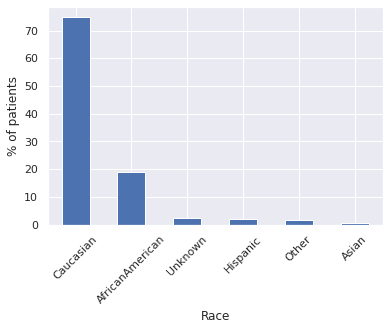

In [ ]:
df["race"].value_counts(normalize=True).mul(100).plot(kind='bar', rot=45);
plt.xlabel("Race")
plt.ylabel("% of patients")

In [ ]:
#With normalize set to True, returns the relative frequency by dividing all values by the sum of values. 
df["race"].value_counts()
df["race"].value_counts(normalize=True)

Caucasian         0.748
AfricanAmerican   0.189
Unknown           0.022
Hispanic          0.020
Other             0.015
Asian             0.006
Name: race, dtype: float64

In our dataset, our patients are predominantly *Caucasian* (75%). The next largest racial group is *AfricanAmerican*, making up 19% of the patients. The remaining race categories (including *Unknown*) compose only 6% of the data.

We also examine the dataset composition by `gender`:



Text(0, 0.5, '% of patients')

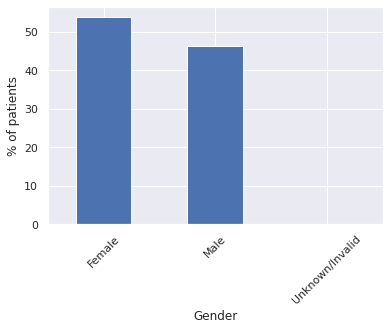

In [ ]:
df["gender"].value_counts(normalize=True).mul(100).plot(kind='bar', rot=45);
plt.xlabel("Gender")
plt.ylabel("% of patients")

In [ ]:
df["gender"].value_counts() 

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

In [ ]:
df["gender"].value_counts(normalize=True).mul(100)

Female            53.759
Male              46.238
Unknown/Invalid    0.003
Name: gender, dtype: float64

Gender is in our case effectively binary (and we have 
no further information how it was operationalized), with both *Female* represented at 54% and *Male* represented at 46%. There are only 3 samples annotated as *Unknown/Invalid*.

Around 54% of the patients were not readmitted to hospital. Approximately 35% of the patients were readmitted to hospital in more than 30 days since their last admission. Approximately 11% of the patients were readmitted in less than 30 days since their last admission.

### Decision point: How do we address smaller group sizes?

When the dataset lacks coverage of certain groups, it means that we will not be able to reliably assess any fairness-related issues. There are three interventions (which could be carried out in a combination):

* **collect more data**: collect more data for groups with fewer samples
* **buckets**: merge some of the groups
* **drop small groups**

The choice of strategy depends on our existing understanding of which groups are at the greatest risk of a harm. In particular, pooling the groups with widely different risks could mask the extent of harms. We generally caution against dropping small groups as this leads to the representational harm of erasure.

If any groups are merged or dropped, these decisions should be annotated / explained (in the datasheet, which we discuss below).

In our case, we will:

* merge the three smallest race groups *Asian*, *Hispanic*, *Other* (similar to [Strack et al., 2014](https://www.hindawi.com/journals/bmri/2014/781670/)), but also retain the original groups for auxiliary assessments.

* drop the gender group *Unknown/Invalid*, because the sample size is so small that no meaningful fairness assessment is possible.

In [ ]:
#drop the gender group Unknown/Invalid
df = df.query("gender != 'Unknown/Invalid'")
df["gender"].value_counts(normalize=True).mul(100)


Female            53.760
Male              46.240
Unknown/Invalid    0.000
Name: gender, dtype: float64

In [ ]:
# retain the original race as race_all, and merge Asian+Hispanic+Other 
df["race_all"] = df["race"]
df["race"] = df["race"].replace({"Asian": "Other", "Hispanic": "Other"})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df["race"].value_counts(normalize=True).mul(100)

Caucasian         74.781
AfricanAmerican   18.877
Other              4.111
Unknown            2.232
Name: race, dtype: float64

Text(0, 0.5, '% of patients')

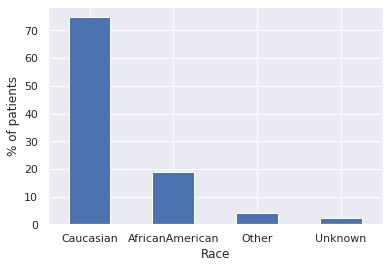

In [ ]:
df["race"].value_counts(normalize=True).mul(100).plot(kind='bar', rot=0)
plt.xlabel("Race")
plt.ylabel("% of patients")

### Exercise

Please examine the distribution of the `age` feature in the dataset.

### Answer

In [ ]:
df["age"].value_counts()

Over 60 years          68538
30-60 years            30716
30 years or younger     2509
Name: age, dtype: int64

In [ ]:
df["age"].value_counts(normalize=True).mul(100)

Over 60 years         67.351
30-60 years           30.184
30 years or younger    2.466
Name: age, dtype: float64

Text(0, 0.5, '% of patients')

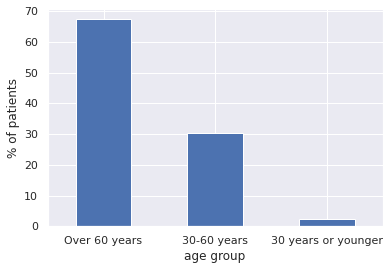

In [ ]:
df["age"].value_counts(normalize=True).mul(100).plot(kind='bar', rot=0)
plt.xlabel("age group")
plt.ylabel("% of patients")

As we might expect, most patients (i.e. 67.4%) admitted into the hospital in our data set belong to the *Over 60 years* category. Although we will not be assessing for age-based fairness-related harms in this tutorial, we will want to document the age imbalance in our dataset.

## **Examining** the choice of label

Next we will answer the question of whether our choice of label (readmission within 30 days) aligns with our goal (identify patients that would benefit from the care management program).

We are making the following assumption: **the greatest benefit from the care management program would go to patients that are** (in the absence of such a program) **most likely to be readmitted into the hospital within 30 days.**

### Predictive validity: How can we check whether our assumptions apply? 

We would like to show that our measurement `readmit_30_days` is correlated with patient characteristics that are related to our construct "benefiting from care management". 

One such characteristic is the general patient health, where we expect that patients that are less healthy are more likely to benefit from care management.

While our data does not contain full health records that would enable us to holistically measure general patient health, the data does contain two relevant features: 
- `had_emergency` which indicates whether the patient spent any days in the emergency room or  
- `had_inpatient_days` which indicates whether the patient spent any days in the hospital (but non-emergency) in the preceding year.

To establish predictive validity, we would like to show that our measurement `readmit_30_days` is predictive of these two observable characteristics.

Let's first understand our data. 

In [ ]:
df.groupby("readmit_30_days")["had_emergency","had_inpatient_days"].describe().T#T means transpose

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


readmit_30_days                0      1
had_emergency      count   90406  11357
                   unique      2      2
                   top     False  False
                   freq    80913   9467
had_inpatient_days count   90406  11357
                   unique      2      2
                   top     False  False
                   freq    61921   5706

In [ ]:
df.groupby("readmit_30_days")["had_emergency","had_inpatient_days"].mean().T 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


readmit_30_days,0,1
had_emergency,0.105,0.166
had_inpatient_days,0.315,0.498


How is the rate calculated? 1-(freq/count) 
https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.GroupBy.mean.html

First, let's check the rate at which the patients with different `readmit_30_days` labels were readmitted in the previous year. We will use a point plot. A point plot represents an estimate of central tendency for a numeric variable by the position of scatter plot points and provides some indication of the uncertainty around that estimate using error bars. 

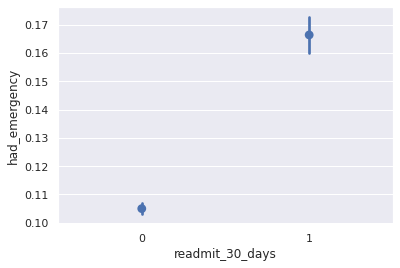

In [ ]:
sns.pointplot(y="had_emergency", x="readmit_30_days", data=df, ci=95, join=False);

- The plot shows that indeed patients with `readmit_30_days=0` have a lower rate of emergency visits in the prior year, whereas patients with `readmit_30_days=1` have a larger rate. (The vertical lines indicate 95% confidence intervals obtained via boostrapping.)

- We see a similar pattern when `readmit_30_days` is used to predict the rate of (non-emergency) hospital visits in the previous year:

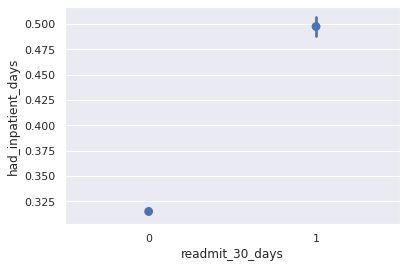

In [ ]:
sns.pointplot(y="had_inpatient_days", x="readmit_30_days",
              data=df, join=False);

Now let's take a look whether the predictiveness is similar across different race groups. First, let's check how well `readmit_30_days` predicts `had_emergency`:

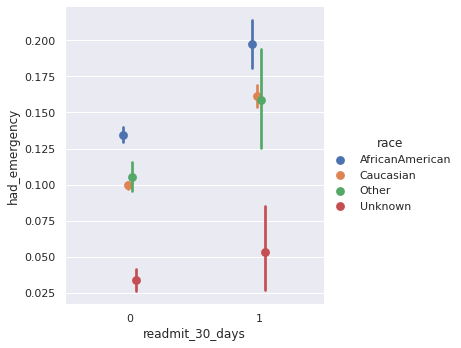

In [ ]:
sns.catplot(y="had_emergency", x="readmit_30_days", hue="race", data=df,
            kind="point", ci=95, dodge=True, join=False);

- The patients in the group *Unknown* have a substantially lower rate of emergency visits in the prior year, regardless of whether they are readmitted in 30 days. The readmission is still positively correlated with `had_emergency`, but note the large error bars (due to small sample sizes).

- We also see that the group with feature value *AfricanAmerican* has a higher rate of emergency visits compared with other groups. However, generally the groups *Caucasian*, *AfricanAmerican* and *Other* follow similar dependence patterns.

We see a similar pattern when `readmit_30_days` is used to predict the rate of (non-emergency) hospital visits in the previous year:

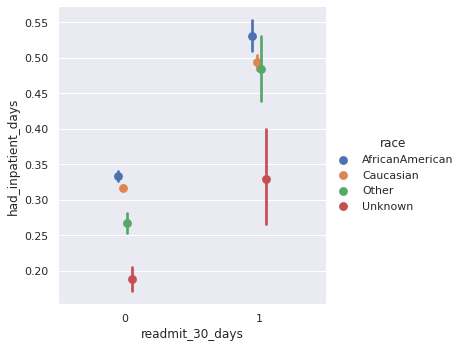

In [ ]:
sns.catplot(y="had_inpatient_days", x="readmit_30_days", hue="race", data=df,
            kind="point", ci=95, dodge=True, join=False);

Again, for *Unknown* the rate of (non-emergency) hospital visits in the previous year is lower than for other groups. In all groups there is a strong positive correlation between `readmit_30_days` and `had_inpatient_days`.

In all cases, we see that readmission in 30 days is predictive of our two measurements of general patient health.

The analysis is also surfacing the fact that patients with the value of race *Unknown* have fewer hospital visits in the preceding year (both emergency and non-emergency) than other groups. In practice, this would be a good reason to reach out to health professionals to investigate this patient cohort, to make sure that we understand why there is the systematic difference.

Note that we have only investigated _predictive validity_, but there are other important aspects of construct validity which we may want to establish (see [Jacobs and Wallach, 2021](https://arxiv.org/abs/1912.05511)).

<a name="exercise-predictive-validity"></a>
### Exercise

Check the predictive validity with respect to `gender` and `age`. Do you see any differences? Can you form a hypothesis why?

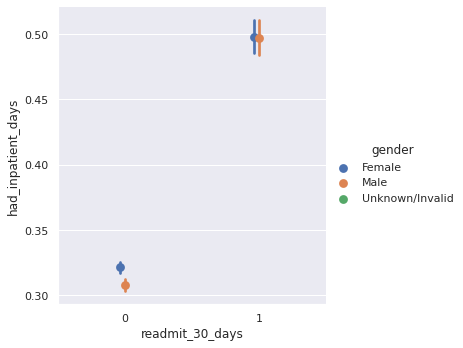

In [ ]:
sns.catplot(y="had_inpatient_days",x="readmit_30_days",hue="gender", data=df,
            kind="point", ci=95, dodge=True, join=False);

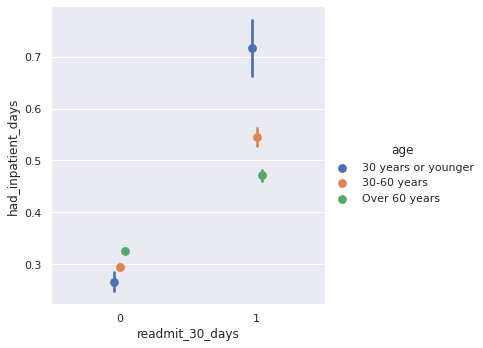

In [ ]:
sns.catplot(y="had_inpatient_days", x="readmit_30_days", hue="age", data=df,
            kind="point", ci=95, dodge=True, join=False);

## Label imbalance



Now that we have established the validity of our label, we will check frequency of its values in our data. The frequency of different labels is an important descriptive characteristic in classification settings for several reasons:

* some classification algorithms and performance measures might not work well with data sets with extreme class imbalance
* in binary classification settings, our ability to evaluate error is often driven by the size of the smaller of the two classes (again, the smaller the sample the larger the uncertainty in estimates)
* label imbalance may exacerbate the problems due to smaller group sizes in fairness assessment



Let's check how many samples in our data are labeled as positive and how many as negative.

In [ ]:
df["readmit_30_days"].value_counts(normalize=True).mul(100)

0   88.840
1   11.160
Name: readmit_30_days, dtype: float64

Text(0, 0.5, '% of patients')

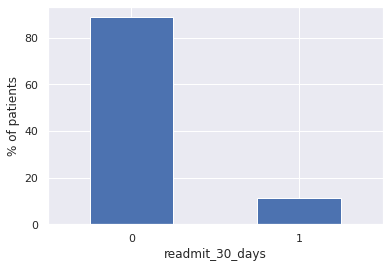

In [ ]:
df["readmit_30_days"].value_counts(normalize=True).mul(100).plot.bar(rot=0)
plt.xlabel("readmit_30_days")
plt.ylabel("% of patients")

As we can see, the target label is heavily skewed towards the patients not being readmitted within 30 days. In our dataset, only 11% of patients were readmitted within 30 days.

Since there are fewer positive examples, we expect that we will have a much larger uncertainty (error bars) in our estimates of *false negative rates* (FNR), compared with *false positive rates* (FPR). This means that there will be larger differences between training FNR and test FNR, even if there is no overfitting, simply because of the smaller sample sizes. 

Our target metric is *balanced error rate*, which is the average of FPR and FNR. The value of this metric is robust to different frequencies of positives and negatives. However, since half of the metric is contributed by FNR, we expect the uncertainty in balanced error values to behave similarly to the uncertainty of FNR.

Now, let's examine how much the label frequencies vary within each group defined by `race`:

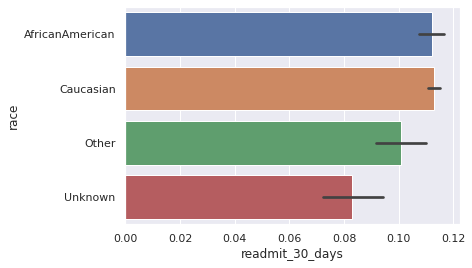

In [ ]:
sns.barplot(x="readmit_30_days", y="race", data=df, ci=95)

In [ ]:
df.groupby("race")["readmit_30_days"].mean().T 

race
AfricanAmerican   0.112
Caucasian         0.113
Other             0.101
Unknown           0.083
Name: readmit_30_days, dtype: float64

We see the rate of *30-day readmission* is similar for the *AfricanAmerican* and *Caucasian* groups, but appears smaller for *Other* and smallest for *Unknown*. The smaller sample size of the *Other* and *Unknown* groups mean that there is more uncertainty around the estimate for these two groups.

Is this consistent with an overall lower rate of hospital visits in the prior year?

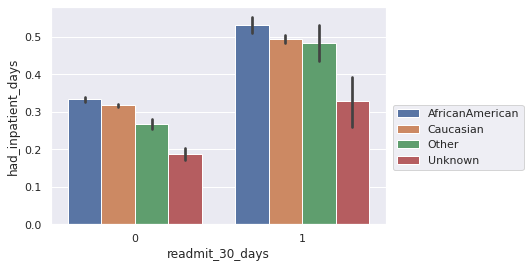

In [ ]:
sns.barplot(x="readmit_30_days", y="had_inpatient_days", hue="race", data=df, ci=95)
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0)

Some more visualisations of the data. What observations can you make?

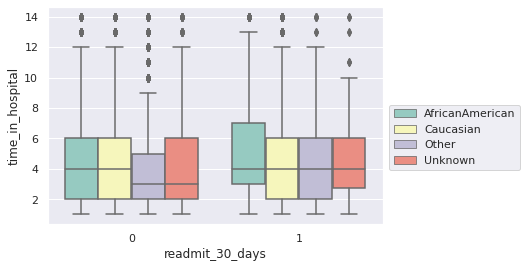

In [ ]:
ax = sns.boxplot(x="readmit_30_days", y="time_in_hospital", hue="race", data=df, palette="Set3")
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0)

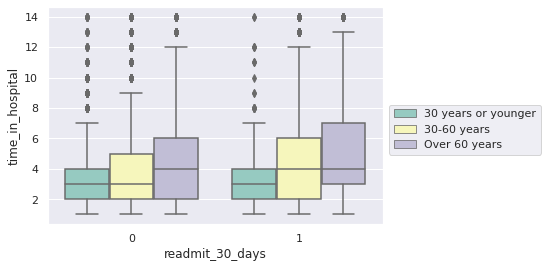

In [ ]:
ax = sns.boxplot(x="readmit_30_days", y="time_in_hospital", hue="age", data=df, palette="Set3")
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0)

A box plot (or box-and-whisker plot) help us visualise the distribution of quantitative data in a way that facilitates comparisons between variables or across levels of a categorical variable. 

The box shows the quartiles of the dataset while the whiskers extend to show the rest of the distribution, except for points that are determined to be “outliers” using a method that is a function of the inter-quartile range.

- Box plots can help us identify imbalances within the variables. For example if the average 

Imbalances can affect the learning process of a machine learning model. 

categorical_features = [
    "race",
    "gender",
    "age",
    "discharge_disposition_id",
    "admission_source_id",
    "medical_specialty",
    "primary_diagnosis",
    "max_glu_serum",
    "A1Cresult",
    "insulin",
    "change",
    "diabetesMed",
    "readmitted"
]

## Proxies for sensitive features



We next investigate which of the features are highly predictive of the sensitive feature *race*; such features are called *proxies*.

While in this tutorial we examine fairness issues through the **impact** of the machine-learning model on different populations, there are other concepts of fairness that seek to analyze how the **model might be using information** contained in the sensitive features, and which of the information uses are justified (often using causal reasoning). More pragmatically, certain uses of sensitive features (or proxies of it) might be illegal in some contexts.

Another reason to understand the proxies is because they might explain why we see differences in impact on different groups even when our model does not have access to the sensitive features directly.

In this section we briefly examine the identification of such proxies (but we don't go into legal or causality considerations).


In the United States, *Medicare* and *Medicaid* are joint federal and state programs to help qualified individuals pay for healthcare expenses. 

- *Medicare* is available to people over the age of 65 and younger individuals with severe illnesses. 
- *Medicaid* is available to all individuals under the age of 65 whose adjusted gross income falls below the Federal Poverty Line. 

First, let's explore the relationship between patients who paid with *Medicaid* and our demographic features. Because *Medicaid* is available to low-income individuals, and race is correlated with socioeconomic status in the United States, we expect there to be a relationship between `race` and paying with *Medicaid*. 

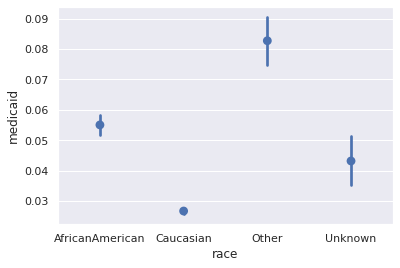

In [ ]:
sns.pointplot(y="medicaid", x="race", data=df, join=False, rot=45);

From our analysis, we see that paying with *Medicaid* does appear to have some relationship with the patient's race. *Caucasian* patients are the least likely to pay with *Medicaid* compared with other groups. If paying with *Medicaid* is a proxy for socioeconomic status, then the patterns we find align with our understanding of wealth and race in the United States.

## Additional validity checks

Similarly as we used predictive validity to check that our label aligns with the construct of "likely to benefit from the care management program", we can use predictive validity to verify that our various features are coherent with each other.

For example, based on the eligibility criteria for *Medicaid* vs *Medicare*, we expect `medicaid` to be negatively correlated with age and `medicare` to be positively correlated with age:

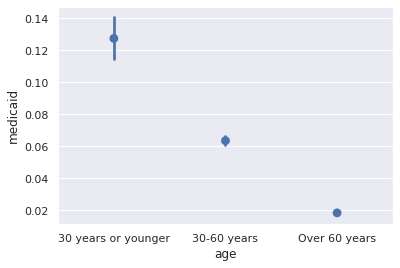

In [ ]:
sns.pointplot(y="medicaid", x="age", data=df, ci=95, join=False);

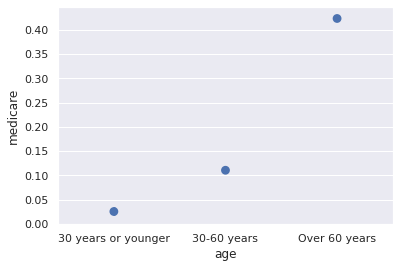

In [ ]:
sns.pointplot(y="medicare", x="age", data=df, ci=95, join=False);

As we see, that's indeed the case.

<a name="exercise-dataset"></a>
## Exercise

Now, let's explore the relationship between paying with `medicare` and other demographic features. In the below sections, feel free to perform any analysis you would like to better understand the relationship between `medicare` and `race` and `gender` in this dataset.

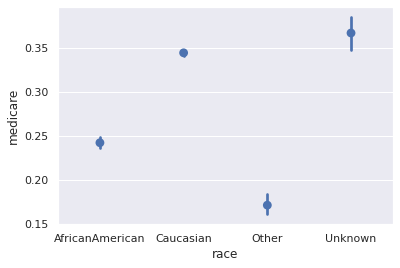

In [ ]:
sns.pointplot(y="medicare", x="race", data=df, ci=95, join=False);

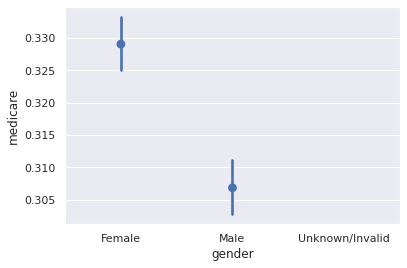

In [ ]:
sns.pointplot(y="medicare", x="gender", data=df, ci=95, join=False);

In [ ]:
#sns.pointplot(y="medicare", x="race", hue="readmit_30_days", data=df, ci=95, join=False);
#plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0)

##Examine Correlations between variables

It is important to understand whether there exist any correlations between the inputs and the label. 

The following code returns the correlation of all features with "readmit_30_days", a single, dependent variable, sorted by "readmit_30_days" in a descending manner.

In [ ]:
df.corr()[['readmit_30_days']].sort_values(by='readmit_30_days', ascending=False)

,readmit_30_days
readmit_30_days,1.000
readmit_binary,0.383
had_inpatient_days,0.122
had_emergency,0.061
number_diagnoses,0.050
time_in_hospital,0.044
num_medications,0.038
had_outpatient_days,0.035
num_lab_procedures,0.020
medicare,0.013


There are no strong positive correlations between the target variable and the predictor which means that there are no linear relationships between them. This also eliminates the risk that the machine learning model will learn to make predictions based on the values of one of the inputs. Hence we must always check whether:
- there are correlations between inputs and the target variable (i.e. label)
- there are correlations between the inputs. If two inputs correlate then we don't need both of those and having both simply increases computational cost.  

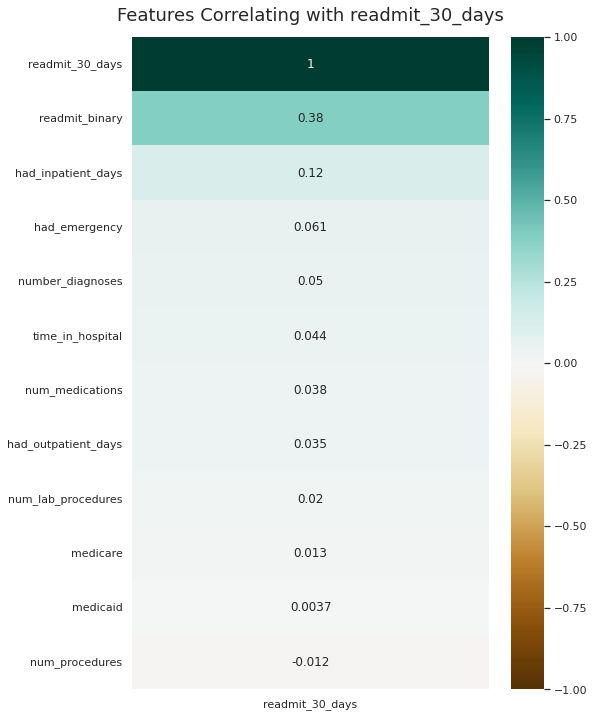

In [ ]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['readmit_30_days']].sort_values(by='readmit_30_days', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with readmit_30_days', fontdict={'fontsize':18}, pad=16);

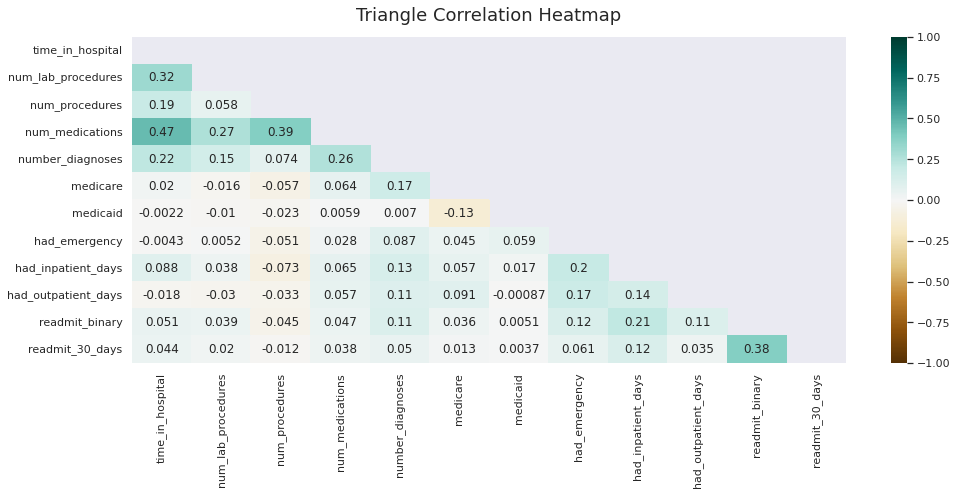

In [ ]:
np.triu(np.ones_like(df.corr()))
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);


Are you noticing any patters?

<a name="datasheets"></a>
## Datasheets for datasets

The _datasheets_ practice was proposed by [Gebru et al. (2018)](https://arxiv.org/abs/1803.09010). A datasheet of a given dataset documents the motivation behind the dataset creation, the dataset composition, collection process, recommended uses and many other characteristics. In the words of Gebru et al., the goal is to
> facilitate better communication between dataset creators
> and dataset consumers, and encourage the machine learning
> community to prioritize transparency and accountability.

In this section, we show how to fill in some of the sections of the datasheet for the dataset that we are using. The information is obtained directly from [Strack et al. (2014)](https://www.hindawi.com/journals/bmri/2014/781670/).

### Example sections of a datasheet

**For what purpose was the dataset created?** *Was there a specific task in mind? Was there a specific gap that needed to be filled?*

In the words of the dataset authors:
> [...] the management of hyperglycemia in the hospitalized patient has a significant bearing on outcome, in terms of both morbidity and mortality. This recognition has led to the development of formalized protocols in the intensive care unit (ICU) setting [...] However, the same cannot be said for most non-ICU inpatient admissions. [...] there are few national assessments of diabetes care in the hospitalized patient which could serve as a baseline for change [in the non-ICU protocols]. The present analysis of a large clinical database was undertaken to examine historical patterns of diabetes care in patients with diabetes admitted to a US hospital and to inform future directions which might lead to improvements in patient safety.

**Who created the dataset (e.g., which team) and on behalf of which entity?**

The dataset was created by [Strack et al. (2014)](https://www.hindawi.com/journals/bmri/2014/781670/): a team of researchers from a variety of disciplines, ranging from computer science to public health, from three institutions (Virginia Commonwealth University, University of Cordoba, and Polish Academy of Sciences).

#### **Composition**

**What do the instances that comprise the dataset represent?**



Each instance in this dataset represents a hospital admission for diabetic patient (diabetes was entered as a possible diagnosis for the patient) whose hospital stay lasted between one to fourteen days.

**Is any information missing from individual instances?**

The features `Payer Code` and `Medical Specialty` have 40,255 and 49,947 missing values, respectively. For `Payer Code`, these missing values are reflected in the category *Unknown*. For `Medical Specialty`, these missing values are reflecting in the category *Missing*. 

For our demographic features, we are missing the `Gender` information for three patients in the dataset. These three records were dropped from our final dataset. Regarding `Race`, the 2,271 missing values were recoded into the `Unknown` race category. 



**Does the dataset identify any subpopulations (e.g., by age, gender)?**

Patients are identified by gender, age group, and race. 

For gender, patients are identified as Male, Female, or Unknown. There were only three instances where the patient gender is *Unknown*, so these records were removed from our dataset.

Gender | Count| Percentage
------ | ------|----------
Male      | 47055     | 46.2%
Female     |  54708     | 53.7%  



For age group, patients are binned into three age buckets: *30 years or younger*, *30-60 years*, *Older than 60 years*.

Age Group |Count| Percentage
------ | ------|----------
30 years or younger      | 2509     | 2.4%
30-60 years       | 30716   | 30.2%
Older than 60 years      |   68538    | 67.4%  


For race, patients are identified as *AfricanAmerican*, *Caucasian*, and *Other*. For individuals whose race information was not collected during hospital admission, their race is listed as *Unknown*.

Race | Count| Percentage
------ | ------|----------
Caucasian      | 76099     | 74.8%
AfricanAmerican     |  19210     | 18.9%  
Other        |     4183         |  4.1%
Unknown        |    2271          | 2.2%

#### **Preprocessing**

**Was any preprocessing/cleaning/labeling of the data done?**

For the `race` feature, the categories of *Asian* and *Hispanic* and *Other* were merged into the *Other* category. The `age` feature was bucketed into 30-year intervals (*30 years and below*, *30 to 60 years*, and *Over 60 years*). The `discharge_disposition_id` was binarized into a boolean outcome on whether an patient was discharged to home.

The full preprocessing code is provided in the file `preprocess.py` of the tutorial [GitHub repository](https://github.com/fairlearn/talks/blob/main/2021_scipy_tutorial/).

Let's examine the file? any thoughts?

- Can we introduce bias at the pro-processing stage?
- How do we deal with missing values? Can imputing missing values introduce unfairness?


#### **Uses**



**Has the dataset been used for any tasks already?** 

This dataset has been used by [Strack et al. (2014)](https://www.hindawi.com/journals/bmri/2014/781670/) to model the relationship between patient readmission and HbA1c measurement during admission, based on primary medical diagnosis.

The dataset is publicly available through the UCI Machine Learning Repository and, as of May 2021, has received over 350,000 views.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
!ls "/content/drive/My Drive/Colab Notebooks/RSS_organised/"

!jupyter nbconvert '/content/drive/My Drive/Colab Notebooks/RSS_organised/Day1EthicalAI.ipynb' &> /dev/null

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 BiasManagement				    Day1EthicalAI.ipynb
'Copy of GCSciPy2021TutorialP1 (1).ipynb'   GCSciPy2021TutorialP1.html
'Copy of GCSciPy2021TutorialP1.ipynb'	    Main.gdoc
